<a href="https://colab.research.google.com/github/shahadalboti/JAAL/blob/main/jaal_Faster_R_cnn_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

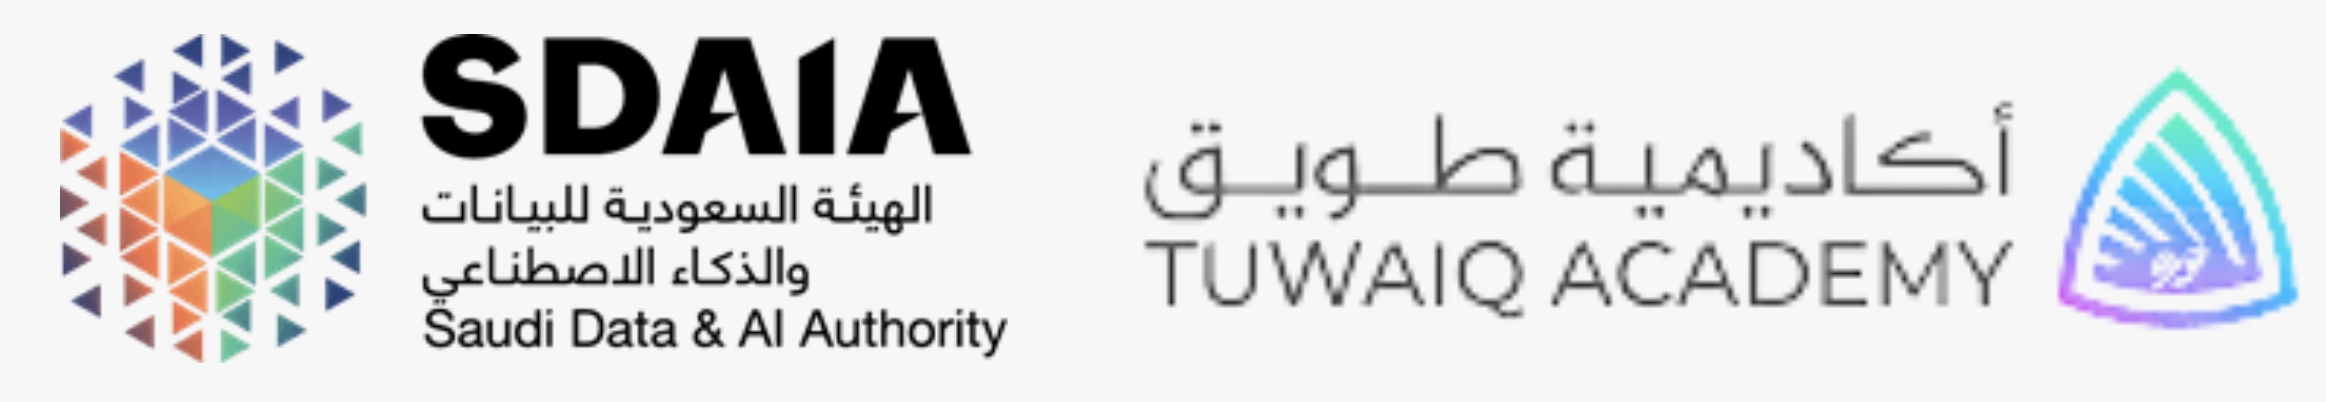





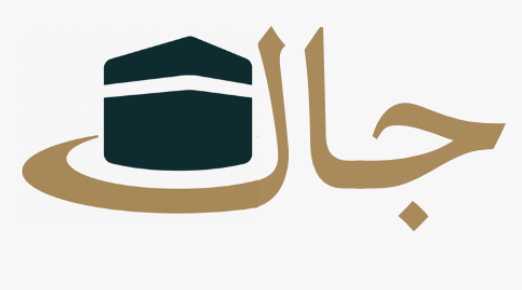

# Jaal:detecte wheelchairs in the masaá area in Mecca to prevent the entry of violators



## Outline
- [ 1- Libraries](#1)
- [ 2- Wheelchairs Detection class](#2)
- [ 3- Dataset](#3)
  - [ 3.1  Visualize one image](#3.1)
  - [ 3.2  Dataset statistics](#3.2)

- [ 4- Model Implementation For Faster R-Cnn](#4)
    - [ 4.1 Train the model](#4.1)
    - [ 4.2 Export](#4.2)
    - [ 4.3 Inference](#4.3)

<a name="1"></a>
# 1 - Libraries

First, let's run the cell below to import some required packages.
- [pandas](https://pandas.pydata.org/) a fast, powerful, flexible and easy to use open source data analysis and manipulation tools.
- [seaborn](https://seaborn.pydata.org/) a Python data visualization library for drawing attractive and informative statistical graphics.
- [numpy](https://numpy.org/) the core library for scientific computing in Python.
- [matplotlib](http://matplotlib.org) a popular library to plot graphs in Python.
- [pickle](https://docs.python.org/3/library/pickle.html) a library that converts a Python object into a byte stream to store it in a file/database, maintain program state across sessions, or transport data over the network.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd

In [ ]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./
!cp vision/references/detection/coco.py ./

Cloning into 'vision'...
remote: Enumerating objects: 392381, done.
remote: Counting objects: 100% (42593/42593), done.
remote: Compressing objects: 100% (2229/2229), done.
remote: Total 392381 (delta 40303), reused 42442 (delta 40236), pack-reused 349788
Receiving objects: 100% (392381/392381), 780.71 MiB | 34.79 MiB/s, done.
Resolving deltas: 100% (362854/362854), done.
fatal: not a git repository (or any of the parent directories): .git
cp: cannot stat 'vision/references/detection/coco.py': No such file or directory


In [ ]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torchvision.transforms import functional as Ff
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

from engine import train_one_epoch, evaluate

In [ ]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [ ]:
# our dataset is in cocoformat, we will need pypcoco tools
from pycocotools.coco import COCO

In [ ]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

<a name="2"></a>
# 2 - Wheelchairs Detection Class

In [ ]:
class WheelDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

<a name="3"></a>
## 3- Dataset

Start by reading the dataset for this code.
- The dataset contains images labeled as 0=person or 1=Wheelchier or
 2 = Not Wheelchier.

- The data set contains 1255 images and 1255 lable for each image, dataset split into tein, test and validate

In [ ]:
dataset_path = "/content/drive/MyDrive/wheelchari-coco1"

In [ ]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())+1
categories

loading annotations into memory...
Done (t=6.81s)
creating index...
index created!


{1: {'id': 1, 'name': 'not wheel chair'},
 2: {'id': 2, 'name': 'person'},
 3: {'id': 3, 'name': 'wheel chair'}}

In [ ]:
n_classes

4

In [ ]:
classes =['__background__','not wheel chair','person', 'wheel chair']
classes

['__background__', 'not wheel chair', 'person', 'wheel chair']

<a name="3.1"></a>
###3.1 Visualize one image

In [ ]:
train_dataset = WheelDetection(root=dataset_path, transforms=get_transforms(True))
dataset_valid = WheelDetection(root=dataset_path, transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


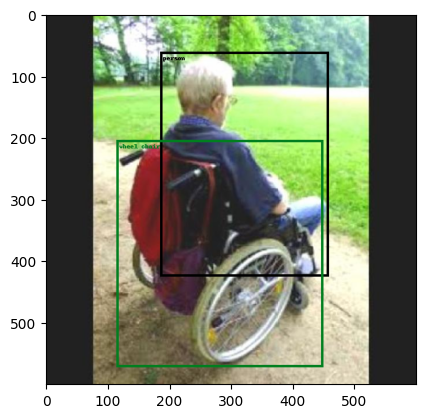

In [ ]:
# Lets view a sample
sample = train_dataset[6]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'],[classes[i] for i in sample[1]['labels']], width=4,font_size=20).permute(1, 2, 0))

<a name="3.2"></a>
###3.2 Dataset statistics

In [ ]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [ ]:
img_properties = get_image_properties('/content/drive/MyDrive/wheelchari-coco1/train/100_png_jpg.rf.00cd7e6d3507a4dfe6b1d4b0ec3679c2.jpg')
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

<a name="4"></a>
## 4 - Model Implementation for Faster R-cnn

Various Deep learning methods can be applied to detect wheechiers. In this notebook we will train Faster R-CNN models. to detect wheelchiers in the Masaa.

In [ ]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:01<00:00, 48.1MB/s]


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
data_loader_valid = DataLoader(dataset_valid, batch_size=4, shuffle=False, num_workers=4,collate_fn=collate_fn)

In [ ]:
images,targets = next(iter(train_loader))

In [ ]:
output = model(images, targets) # just make sure this runs without error

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = model.to(device)

<a name="4.1"></a>
###4.1 Train the model

In [ ]:
def train_one_epoch1(model, optimizer, loader, device, epoch,print_freq=20):
    model.to(device)
    model.train()

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000 # do lr warmup
        warmup_iters = min(1000, len(loader) - 1)

        lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [ ]:

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
num_epochs=75

for epoch in range(num_epochs):
    train_one_epoch1(model, optimizer, train_loader, device, epoch,print_freq=20)
    lr_scheduler.step()
    # evaluate(model, data_loader_valid, device=device)


100%|██████████| 222/222 [01:24<00:00,  2.63it/s]


Epoch 0, lr: 0.005000, loss: 1.215859, loss_classifier: 0.495908, loss_box: 0.663892, loss_rpn_box: 0.027092, loss_object: 0.028967


100%|██████████| 222/222 [00:36<00:00,  6.11it/s]


Epoch 1, lr: 0.005000, loss: 0.854729, loss_classifier: 0.332596, loss_box: 0.477891, loss_rpn_box: 0.024158, loss_object: 0.020085


100%|██████████| 222/222 [00:34<00:00,  6.42it/s]


Epoch 2, lr: 0.005000, loss: 0.765711, loss_classifier: 0.295137, loss_box: 0.434372, loss_rpn_box: 0.021470, loss_object: 0.014733


100%|██████████| 222/222 [00:34<00:00,  6.46it/s]


Epoch 3, lr: 0.000500, loss: 0.618233, loss_classifier: 0.247822, loss_box: 0.343025, loss_rpn_box: 0.016887, loss_object: 0.010499


100%|██████████| 222/222 [00:35<00:00,  6.34it/s]


Epoch 4, lr: 0.000500, loss: 0.588364, loss_classifier: 0.234697, loss_box: 0.329436, loss_rpn_box: 0.015754, loss_object: 0.008478


100%|██████████| 222/222 [00:33<00:00,  6.63it/s]


Epoch 5, lr: 0.000500, loss: 0.578337, loss_classifier: 0.230406, loss_box: 0.324740, loss_rpn_box: 0.015151, loss_object: 0.008040


100%|██████████| 222/222 [00:33<00:00,  6.54it/s]


Epoch 6, lr: 0.000050, loss: 0.553858, loss_classifier: 0.222412, loss_box: 0.308801, loss_rpn_box: 0.014589, loss_object: 0.008056


100%|██████████| 222/222 [00:34<00:00,  6.48it/s]


Epoch 7, lr: 0.000050, loss: 0.545647, loss_classifier: 0.220615, loss_box: 0.302589, loss_rpn_box: 0.014792, loss_object: 0.007652


100%|██████████| 222/222 [00:34<00:00,  6.44it/s]


Epoch 8, lr: 0.000050, loss: 0.549737, loss_classifier: 0.222780, loss_box: 0.305127, loss_rpn_box: 0.014524, loss_object: 0.007306


100%|██████████| 222/222 [00:34<00:00,  6.47it/s]


Epoch 9, lr: 0.000005, loss: 0.546119, loss_classifier: 0.222926, loss_box: 0.300777, loss_rpn_box: 0.014563, loss_object: 0.007853


100%|██████████| 222/222 [00:34<00:00,  6.49it/s]


Epoch 10, lr: 0.000005, loss: 0.533488, loss_classifier: 0.218680, loss_box: 0.292428, loss_rpn_box: 0.014736, loss_object: 0.007643


100%|██████████| 222/222 [00:33<00:00,  6.56it/s]


Epoch 11, lr: 0.000005, loss: 0.537073, loss_classifier: 0.217714, loss_box: 0.297111, loss_rpn_box: 0.014483, loss_object: 0.007765


100%|██████████| 222/222 [00:35<00:00,  6.25it/s]


Epoch 12, lr: 0.000001, loss: 0.538973, loss_classifier: 0.220094, loss_box: 0.297306, loss_rpn_box: 0.014349, loss_object: 0.007224


100%|██████████| 222/222 [00:33<00:00,  6.54it/s]


Epoch 13, lr: 0.000001, loss: 0.543826, loss_classifier: 0.222248, loss_box: 0.299369, loss_rpn_box: 0.014312, loss_object: 0.007898


100%|██████████| 222/222 [00:34<00:00,  6.42it/s]


Epoch 14, lr: 0.000001, loss: 0.556097, loss_classifier: 0.225621, loss_box: 0.308055, loss_rpn_box: 0.014533, loss_object: 0.007888


100%|██████████| 222/222 [00:34<00:00,  6.46it/s]


Epoch 15, lr: 0.000000, loss: 0.547986, loss_classifier: 0.223753, loss_box: 0.302267, loss_rpn_box: 0.014297, loss_object: 0.007670


100%|██████████| 222/222 [00:34<00:00,  6.43it/s]


Epoch 16, lr: 0.000000, loss: 0.547505, loss_classifier: 0.223788, loss_box: 0.302255, loss_rpn_box: 0.014251, loss_object: 0.007211


100%|██████████| 222/222 [00:35<00:00,  6.20it/s]


Epoch 17, lr: 0.000000, loss: 0.546934, loss_classifier: 0.222610, loss_box: 0.302015, loss_rpn_box: 0.014621, loss_object: 0.007688


100%|██████████| 222/222 [00:33<00:00,  6.57it/s]


Epoch 18, lr: 0.000000, loss: 0.549885, loss_classifier: 0.223095, loss_box: 0.304427, loss_rpn_box: 0.014797, loss_object: 0.007566


100%|██████████| 222/222 [00:33<00:00,  6.56it/s]


Epoch 19, lr: 0.000000, loss: 0.539570, loss_classifier: 0.219090, loss_box: 0.298587, loss_rpn_box: 0.014408, loss_object: 0.007485


100%|██████████| 222/222 [00:34<00:00,  6.42it/s]


Epoch 20, lr: 0.000000, loss: 0.531759, loss_classifier: 0.216994, loss_box: 0.293067, loss_rpn_box: 0.014413, loss_object: 0.007285


100%|██████████| 222/222 [00:34<00:00,  6.53it/s]


Epoch 21, lr: 0.000000, loss: 0.534581, loss_classifier: 0.216318, loss_box: 0.296231, loss_rpn_box: 0.014610, loss_object: 0.007423


100%|██████████| 222/222 [00:33<00:00,  6.54it/s]


Epoch 22, lr: 0.000000, loss: 0.537782, loss_classifier: 0.218973, loss_box: 0.296111, loss_rpn_box: 0.014376, loss_object: 0.008322


100%|██████████| 222/222 [00:33<00:00,  6.54it/s]


Epoch 23, lr: 0.000000, loss: 0.544563, loss_classifier: 0.221219, loss_box: 0.301635, loss_rpn_box: 0.014208, loss_object: 0.007501


100%|██████████| 222/222 [00:34<00:00,  6.44it/s]


Epoch 24, lr: 0.000000, loss: 0.541625, loss_classifier: 0.221333, loss_box: 0.298542, loss_rpn_box: 0.014336, loss_object: 0.007414


100%|██████████| 222/222 [00:35<00:00,  6.33it/s]


Epoch 25, lr: 0.000000, loss: 0.537776, loss_classifier: 0.218673, loss_box: 0.296758, loss_rpn_box: 0.014630, loss_object: 0.007715


100%|██████████| 222/222 [00:33<00:00,  6.53it/s]


Epoch 26, lr: 0.000000, loss: 0.548359, loss_classifier: 0.223316, loss_box: 0.302866, loss_rpn_box: 0.014452, loss_object: 0.007725


100%|██████████| 222/222 [00:33<00:00,  6.61it/s]


Epoch 27, lr: 0.000000, loss: 0.543337, loss_classifier: 0.219681, loss_box: 0.301096, loss_rpn_box: 0.014604, loss_object: 0.007955


100%|██████████| 222/222 [00:33<00:00,  6.58it/s]


Epoch 28, lr: 0.000000, loss: 0.541298, loss_classifier: 0.221289, loss_box: 0.298317, loss_rpn_box: 0.014382, loss_object: 0.007310


100%|██████████| 222/222 [00:34<00:00,  6.52it/s]


Epoch 29, lr: 0.000000, loss: 0.547453, loss_classifier: 0.222310, loss_box: 0.303390, loss_rpn_box: 0.014498, loss_object: 0.007255


100%|██████████| 222/222 [00:33<00:00,  6.64it/s]


Epoch 30, lr: 0.000000, loss: 0.544346, loss_classifier: 0.220796, loss_box: 0.301772, loss_rpn_box: 0.014499, loss_object: 0.007280


100%|██████████| 222/222 [00:33<00:00,  6.61it/s]


Epoch 31, lr: 0.000000, loss: 0.543596, loss_classifier: 0.220753, loss_box: 0.301000, loss_rpn_box: 0.014468, loss_object: 0.007376


100%|██████████| 222/222 [00:33<00:00,  6.58it/s]


Epoch 32, lr: 0.000000, loss: 0.550128, loss_classifier: 0.224370, loss_box: 0.303967, loss_rpn_box: 0.014213, loss_object: 0.007578


100%|██████████| 222/222 [00:35<00:00,  6.18it/s]


Epoch 33, lr: 0.000000, loss: 0.535404, loss_classifier: 0.218228, loss_box: 0.295726, loss_rpn_box: 0.014137, loss_object: 0.007313


100%|██████████| 222/222 [00:33<00:00,  6.66it/s]


Epoch 34, lr: 0.000000, loss: 0.540071, loss_classifier: 0.220848, loss_box: 0.297205, loss_rpn_box: 0.014525, loss_object: 0.007493


100%|██████████| 222/222 [00:33<00:00,  6.55it/s]


Epoch 35, lr: 0.000000, loss: 0.550224, loss_classifier: 0.223544, loss_box: 0.304401, loss_rpn_box: 0.014485, loss_object: 0.007794


100%|██████████| 222/222 [00:33<00:00,  6.54it/s]


Epoch 36, lr: 0.000000, loss: 0.536734, loss_classifier: 0.219880, loss_box: 0.294989, loss_rpn_box: 0.014270, loss_object: 0.007596


100%|██████████| 222/222 [00:35<00:00,  6.30it/s]


Epoch 37, lr: 0.000000, loss: 0.550995, loss_classifier: 0.223164, loss_box: 0.305521, loss_rpn_box: 0.014529, loss_object: 0.007781


100%|██████████| 222/222 [00:34<00:00,  6.52it/s]


Epoch 38, lr: 0.000000, loss: 0.546948, loss_classifier: 0.222608, loss_box: 0.302165, loss_rpn_box: 0.014447, loss_object: 0.007730


100%|██████████| 222/222 [00:33<00:00,  6.62it/s]


Epoch 39, lr: 0.000000, loss: 0.546186, loss_classifier: 0.220469, loss_box: 0.304185, loss_rpn_box: 0.014563, loss_object: 0.006969


100%|██████████| 222/222 [00:33<00:00,  6.56it/s]


Epoch 40, lr: 0.000000, loss: 0.545464, loss_classifier: 0.222426, loss_box: 0.300950, loss_rpn_box: 0.014400, loss_object: 0.007688


100%|██████████| 222/222 [00:36<00:00,  6.10it/s]


Epoch 41, lr: 0.000000, loss: 0.543164, loss_classifier: 0.220867, loss_box: 0.300029, loss_rpn_box: 0.014468, loss_object: 0.007799


100%|██████████| 222/222 [00:34<00:00,  6.49it/s]


Epoch 42, lr: 0.000000, loss: 0.538596, loss_classifier: 0.218817, loss_box: 0.297630, loss_rpn_box: 0.014431, loss_object: 0.007718


100%|██████████| 222/222 [00:34<00:00,  6.40it/s]


Epoch 43, lr: 0.000000, loss: 0.549121, loss_classifier: 0.223010, loss_box: 0.303856, loss_rpn_box: 0.014531, loss_object: 0.007724


100%|██████████| 222/222 [00:34<00:00,  6.36it/s]


Epoch 44, lr: 0.000000, loss: 0.536615, loss_classifier: 0.217674, loss_box: 0.296667, loss_rpn_box: 0.014446, loss_object: 0.007827


100%|██████████| 222/222 [00:34<00:00,  6.46it/s]


Epoch 45, lr: 0.000000, loss: 0.550776, loss_classifier: 0.224172, loss_box: 0.304505, loss_rpn_box: 0.014220, loss_object: 0.007878


100%|██████████| 222/222 [00:34<00:00,  6.52it/s]


Epoch 46, lr: 0.000000, loss: 0.552343, loss_classifier: 0.225141, loss_box: 0.305040, loss_rpn_box: 0.014610, loss_object: 0.007553


100%|██████████| 222/222 [00:34<00:00,  6.44it/s]


Epoch 47, lr: 0.000000, loss: 0.539996, loss_classifier: 0.218890, loss_box: 0.298587, loss_rpn_box: 0.014619, loss_object: 0.007900


100%|██████████| 222/222 [00:33<00:00,  6.55it/s]


Epoch 48, lr: 0.000000, loss: 0.536998, loss_classifier: 0.219942, loss_box: 0.294975, loss_rpn_box: 0.014725, loss_object: 0.007356


100%|██████████| 222/222 [00:36<00:00,  6.12it/s]


Epoch 49, lr: 0.000000, loss: 0.548350, loss_classifier: 0.224185, loss_box: 0.302069, loss_rpn_box: 0.014497, loss_object: 0.007599


100%|██████████| 222/222 [00:34<00:00,  6.52it/s]


Epoch 50, lr: 0.000000, loss: 0.545926, loss_classifier: 0.221915, loss_box: 0.302204, loss_rpn_box: 0.014460, loss_object: 0.007346


100%|██████████| 222/222 [00:33<00:00,  6.63it/s]


Epoch 51, lr: 0.000000, loss: 0.548667, loss_classifier: 0.222580, loss_box: 0.304036, loss_rpn_box: 0.014428, loss_object: 0.007622


100%|██████████| 222/222 [00:33<00:00,  6.58it/s]


Epoch 52, lr: 0.000000, loss: 0.536762, loss_classifier: 0.218680, loss_box: 0.296443, loss_rpn_box: 0.014482, loss_object: 0.007158


100%|██████████| 222/222 [00:34<00:00,  6.40it/s]


Epoch 53, lr: 0.000000, loss: 0.540728, loss_classifier: 0.219602, loss_box: 0.299251, loss_rpn_box: 0.014429, loss_object: 0.007445


100%|██████████| 222/222 [00:35<00:00,  6.33it/s]


Epoch 54, lr: 0.000000, loss: 0.541679, loss_classifier: 0.219558, loss_box: 0.300056, loss_rpn_box: 0.014540, loss_object: 0.007524


100%|██████████| 222/222 [00:33<00:00,  6.57it/s]


Epoch 55, lr: 0.000000, loss: 0.548635, loss_classifier: 0.222825, loss_box: 0.303384, loss_rpn_box: 0.014781, loss_object: 0.007646


100%|██████████| 222/222 [00:33<00:00,  6.55it/s]


Epoch 56, lr: 0.000000, loss: 0.539733, loss_classifier: 0.218312, loss_box: 0.298743, loss_rpn_box: 0.014634, loss_object: 0.008044


100%|██████████| 222/222 [00:35<00:00,  6.17it/s]


Epoch 57, lr: 0.000000, loss: 0.552181, loss_classifier: 0.224075, loss_box: 0.305919, loss_rpn_box: 0.014633, loss_object: 0.007554


100%|██████████| 222/222 [00:34<00:00,  6.44it/s]


Epoch 58, lr: 0.000000, loss: 0.540421, loss_classifier: 0.217691, loss_box: 0.300233, loss_rpn_box: 0.014682, loss_object: 0.007815


100%|██████████| 222/222 [00:34<00:00,  6.48it/s]


Epoch 59, lr: 0.000000, loss: 0.547775, loss_classifier: 0.222582, loss_box: 0.302908, loss_rpn_box: 0.014621, loss_object: 0.007664


100%|██████████| 222/222 [00:33<00:00,  6.60it/s]


Epoch 60, lr: 0.000000, loss: 0.540116, loss_classifier: 0.221025, loss_box: 0.297191, loss_rpn_box: 0.014469, loss_object: 0.007431


100%|██████████| 222/222 [00:34<00:00,  6.47it/s]


Epoch 61, lr: 0.000000, loss: 0.547273, loss_classifier: 0.221706, loss_box: 0.303149, loss_rpn_box: 0.014589, loss_object: 0.007829


100%|██████████| 222/222 [00:34<00:00,  6.43it/s]


Epoch 62, lr: 0.000000, loss: 0.546161, loss_classifier: 0.222693, loss_box: 0.301630, loss_rpn_box: 0.014507, loss_object: 0.007330


100%|██████████| 222/222 [00:34<00:00,  6.48it/s]


Epoch 63, lr: 0.000000, loss: 0.533542, loss_classifier: 0.215918, loss_box: 0.295664, loss_rpn_box: 0.014522, loss_object: 0.007439


100%|██████████| 222/222 [00:33<00:00,  6.55it/s]


Epoch 64, lr: 0.000000, loss: 0.555002, loss_classifier: 0.225195, loss_box: 0.307261, loss_rpn_box: 0.014954, loss_object: 0.007591


100%|██████████| 222/222 [00:35<00:00,  6.24it/s]


Epoch 65, lr: 0.000000, loss: 0.545548, loss_classifier: 0.221974, loss_box: 0.301500, loss_rpn_box: 0.014457, loss_object: 0.007617


100%|██████████| 222/222 [00:34<00:00,  6.41it/s]


Epoch 66, lr: 0.000000, loss: 0.545839, loss_classifier: 0.221250, loss_box: 0.302470, loss_rpn_box: 0.014567, loss_object: 0.007552


100%|██████████| 222/222 [00:34<00:00,  6.48it/s]


Epoch 67, lr: 0.000000, loss: 0.544087, loss_classifier: 0.221858, loss_box: 0.300057, loss_rpn_box: 0.014406, loss_object: 0.007766


100%|██████████| 222/222 [00:34<00:00,  6.51it/s]


Epoch 68, lr: 0.000000, loss: 0.546308, loss_classifier: 0.222112, loss_box: 0.301676, loss_rpn_box: 0.014634, loss_object: 0.007886


100%|██████████| 222/222 [00:33<00:00,  6.55it/s]


Epoch 69, lr: 0.000000, loss: 0.542840, loss_classifier: 0.221486, loss_box: 0.299338, loss_rpn_box: 0.014474, loss_object: 0.007542


100%|██████████| 222/222 [00:34<00:00,  6.44it/s]


Epoch 70, lr: 0.000000, loss: 0.547697, loss_classifier: 0.222382, loss_box: 0.303352, loss_rpn_box: 0.014362, loss_object: 0.007602


100%|██████████| 222/222 [00:34<00:00,  6.37it/s]


Epoch 71, lr: 0.000000, loss: 0.549383, loss_classifier: 0.224473, loss_box: 0.302539, loss_rpn_box: 0.014512, loss_object: 0.007858


100%|██████████| 222/222 [00:35<00:00,  6.19it/s]


Epoch 72, lr: 0.000000, loss: 0.528492, loss_classifier: 0.216181, loss_box: 0.290957, loss_rpn_box: 0.014093, loss_object: 0.007262


100%|██████████| 222/222 [00:34<00:00,  6.48it/s]


Epoch 73, lr: 0.000000, loss: 0.532842, loss_classifier: 0.216931, loss_box: 0.293860, loss_rpn_box: 0.014409, loss_object: 0.007641


100%|██████████| 222/222 [00:35<00:00,  6.32it/s]

Epoch 74, lr: 0.000000, loss: 0.543067, loss_classifier: 0.219855, loss_box: 0.300890, loss_rpn_box: 0.014734, loss_object: 0.007588


<a name="4.2"></a>
###4.2 Export the model

In [ ]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [ ]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 43.0 MB/s eta 0:00:00


In [ ]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.0 MB/s eta 0:00:00


In [ ]:
# Create dummy input data to export the model
# Replace with appropriate input dimensions and data
dummy_input = torch.randn(4, 3, 224, 224).to(device)  # Example: 1 batch of 3-channel 224x224 image

# Export the model to ONNX format
onnx_path = "faster_rcnn_model-jaal.onnx"
torch.onnx.export(model, dummy_input, onnx_path, verbose=True, input_names=['input'], output_names=['output'])


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
import onnxruntime
# Load the ONNX model
onnx_model_path = "/content/faster_rcnn_model-jaal.onnx"  # Replace with the path to your ONNX model
session = onnxruntime.InferenceSession(onnx_model_path,providers=['AzureExecutionProvider', 'CPUExecutionProvider'])

<a name="4.3"></a>
###4.3 Inference

In [ ]:
test_data= WheelDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=1.92s)
creating index...
index created!


In [ ]:
img, _ = test_data[0]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

In [ ]:
pred

{'boxes': tensor([[261.2818, 234.4754, 439.2263, 458.2990],
         [241.2232, 111.7564, 430.5351, 457.1042],
         [ 70.8602, 174.5484, 268.5385, 407.2728],
         [ 74.4161, 265.8909, 301.2786, 426.5807]], device='cuda:0'),
 'labels': tensor([3, 2, 2, 3], device='cuda:0'),
 'scores': tensor([0.9983, 0.9982, 0.9965, 0.1880], device='cuda:0')}

In [ ]:
from torch import tensor
targ =[{'boxes': tensor([[236.2778, 113.1419, 429.1326, 452.7046],
         [ 72.7678, 171.5191, 275.5193, 410.5388],
         [259.4561, 230.7157, 442.1990, 462.6949],
         [ 83.8117, 237.2652, 309.5104, 437.5142]], device='cuda:0'),
 'labels': tensor([2, 2, 3, 3], device='cuda:0')}]

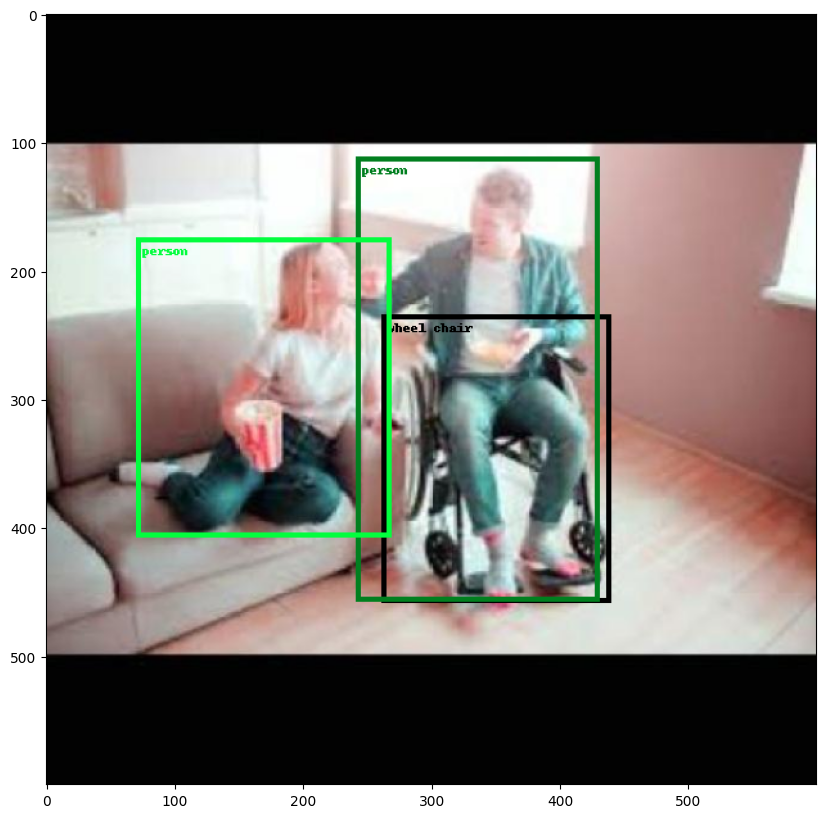

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [ ]:
!pip install torchmetrics

In [ ]:
from torch import tensor
from torchmetrics.detection import MeanAveragePrecision
metric = MeanAveragePrecision(iou_type="bbox")
metric.update([pred], targ)
from pprint import pprint
pprint(metric.compute())

{'classes': tensor([2, 3], dtype=torch.int32),
 'map': tensor(0.8262),
 'map_50': tensor(1.),
 'map_75': tensor(0.7525),
 'map_large': tensor(0.8262),
 'map_medium': tensor(-1.),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.4750),
 'mar_10': tensor(0.8250),
 'mar_100': tensor(0.8250),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.8250),
 'mar_medium': tensor(-1.),
 'mar_small': tensor(-1.)}


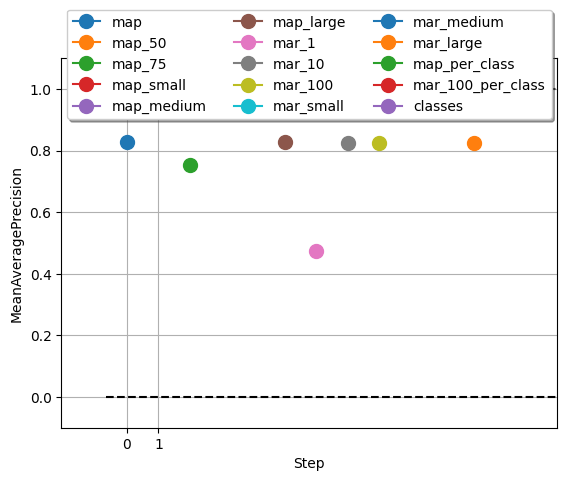

In [ ]:
fig_, ax_ = metric.plot()

In [ ]:
img, _ = test_data[-5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

In [ ]:
pred

{'boxes': tensor([[ 10.5639, 142.0567, 586.0698, 478.1593]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'scores': tensor([0.9993], device='cuda:0')}

In [ ]:
from torch import tensor
targ =[{'boxes': tensor([[ 63.8035, 197.1429, 410.9423, 497.6991],
         [128.8194,  94.9118, 446.3059, 441.2590]], device='cuda:0'),
 'labels': tensor([3, 2], device='cuda:0')}]

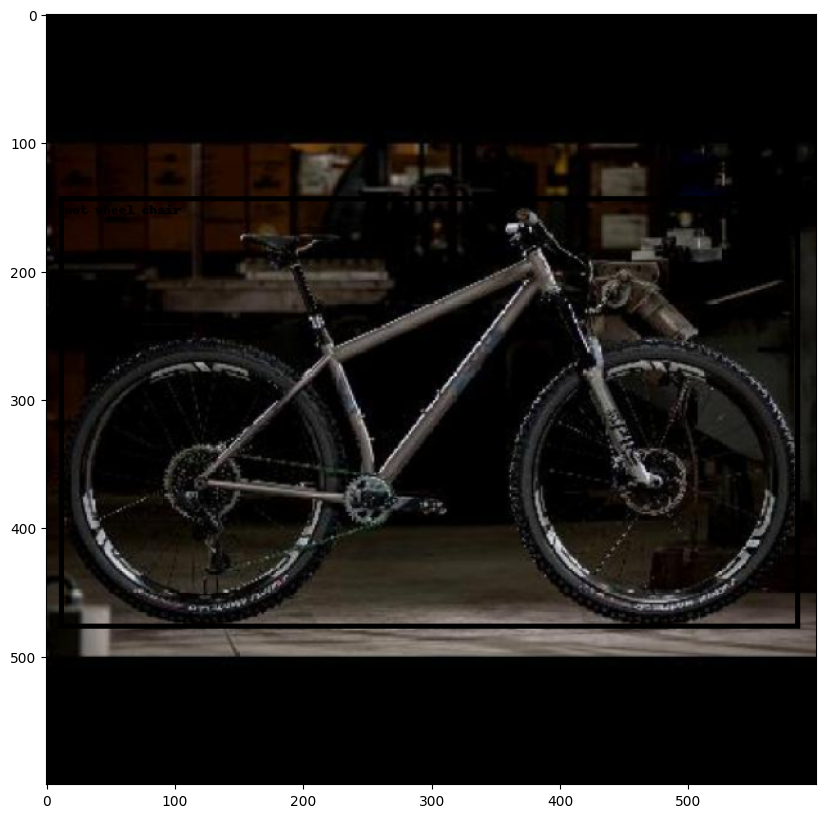

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

**Team Member:**
Noura Alsaqer,
Shahad Alboti,
Nouf Alghamdi